In [2]:
from root_pandas import read_root
import numpy as np
from ROOT import TFile,TTree
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

/home/jcordero/anaconda3/lib/python3.6/site-packages/root_numpy/__init__.py:46: RuntimeWarning: numpy 1.14.3 is currently installed but you installed root_numpy against numpy 1.12.1. Please consider reinstalling root_numpy for this numpy version.
  RuntimeWarning)


In [168]:
def expexp(x,*param):
    lamb, x0, N ,y0 = param 
    return N*np.exp(np.exp(-lamb*(x - x0))) + y0 

def Sexp(x,*param):
    lamb0, x0, N0 ,y0,lamb1, x1, N1 ,y1 = param 
    return (N0*np.exp(-lamb0*(x - x0)) + y0) + (N1*np.exp(-lamb1*(x - x1)) + y1 )

def expSexp(x,*param):
    lamb0, x0, N0 ,y0,lamb1, x1, N1 ,y1 = param 
    return np.exp((N0*np.exp(-lamb0*(x - x0)) + y0) + (N1*np.exp(-lamb1*(x - x1)) + y1 ))

def exp2(x,*param):
    lamb, x0, N ,y0 = param 
    return N*np.exp(-lamb*(x - x0)) + y0 
def exp(x,*param):
    lamb, x0, N = param 
    return N*np.exp(-lamb*(x - x0))
def poly2(x,*param):
    return param[0] + param[1]*x + param[2]*x*x

def chi2(x,sig,func,parm,y):
    chi = 0
    for xi,si in zip(x,sig):
        chi+= ((func(xi,*parm)-xi)**2)/(si)**2
    return chi



In [4]:
def R_decay(pu,funcName='exp2'):
    '''
    exp2 : lamb, x0, N ,y0 = param 
    exp  : lamb, x0, N     = param 
    poly2: a, b, c         = param
    ''';
    
    P0 = {  
            'exp2':{    
                        '0':[0.5,6,  10,0],
                        '1':[0.5,6,  20,0],
                        '2':[0.5,6,  30,0],
                       '10':[0.5,6, 100,0],
                       '20':[0.5,6, 200,0],
                       '30':[0.5,6, 300,0],
                       '50':[0.5,6, 500,0],
                       '75':[0.5,6, 800,0],
                      '100':[0.5,6,1000,0],
                      '140':[0.5,6,1400,0],
                      '175':[0.5,6,1700,0],
                      '200':[0.5,6,2000,0],
                    },
            'exp':{
                '0':[0.5,6,  10],
                '1':[0.5,6,  20],
                '2':[0.5,6,  30],
               '10':[0.5,6, 100],
               '20':[0.5,6, 200],
               '30':[0.5,6, 300],
               '50':[0.5,6, 500],
               '75':[0.5,6, 800],
              '100':[0.5,6,1000],
              '140':[0.5,6,1400],
              '175':[0.5,6,1700],
              '200':[0.5,6,2000],
                },
         }
    
    lambs = []
    n = 0
    fig = plt.figure(figsize=(8,18))
    for di in Disk[pu]:
        R,wei = [],[]

        mask = [False for _ in zP[pu]]
        mask_nonOverlap = [False for _ in zP[pu]]    

        n+=1
        plt.subplot(4,1,n)
        for ri in Ring[pu]:
            mask = Disk[pu][di]
            mask = np.logical_and(mask,Ring[pu][ri])
            R += list(rP[pu][mask])
            wei += [1/NRing[ri] for _ in rP[pu][mask]]
        

        h = np.histogram(
                            R,
                            weights = wei,
                            range = [6,26],
                            bins = 200,    
                            )    
        Data = h[0]
        mask = Data!=0


        xc = (h[1][:-1]+h[1][1:])/2
        plt.plot(xc[mask],
                 Data[mask])
        func = exp2
        parm = curve_fit(func,xc[mask],Data[mask],p0=P0[funcName][pu])
        lamb,dlamb = parm[0][0],parm[1][0][0]

        plt.plot(xc[mask],
                 func(xc[mask],*parm[0]),
                 '-k')
        ax = plt.gca()
        ylim = ax.get_ylim()
        xlim = ax.get_xlim()
        
        lenPosy = ylim[0]+(ylim[1]-ylim[0])*0.6
        lenPosx = xlim[0]+(xlim[1]-xlim[0])*0.6
        #print(lenPosx,lenPosy)
        plt.text(lenPosx,lenPosy,
                 r'$\lambda$_'+'D'+str(di)+'= '+str(round(lamb,3))+'+-'+str(round(dlamb,5))+'\n',
                 bbox=dict(facecolor = 'white')
                )    
        plt.title('Disk '+str(di))
        plt.ylabel('# Counts')
        plt.xlabel('R[cm]')
        plt.grid(linestyle='--')
        
        plt.tight_layout()
        lambs.append(parm[0][0])
    fig.savefig(figPath+'Disks_radial_'+pu+'.png')
    return lambs

In [5]:
Path='/home/jcordero/CMS/BRIL/data/Cluster/'
figPath = '/home/jcordero/CMS/BRIL/figs/Cluster/'
x,y,z = [],[],[]
phi,theta = [],[]
merge = []

In [6]:
PU=['1','2','30','50','75','100','140']
data = {}
for pu in PU:
    data[pu] = read_root(Path+'Cluster_'+pu+'.0_00.root','cluster_tree')

TClass::Init:0: RuntimeWarning: no dictionary for class ROOT::TIOFeatures is available


In [7]:
xP,yP,zP = {},{},{}
phiP,thetaP,mergeP,rP = {},{},{},{}
for pu in PU:
    xP[pu]      = np.array(data[pu].CluX)
    yP[pu]      = np.array(data[pu].CluY)
    zP[pu]      = np.array(data[pu].CluZ)
    phiP[pu]    = np.array(data[pu].CluPhi)
    thetaP[pu]  = np.array(data[pu].CluTheta)
    mergeP[pu]  = np.array(data[pu].CluMerge)
    rP[pu]      = np.sqrt(xP[pu]**2 + yP[pu]**2)    

In [8]:
rMaskRange = {
                1:[6.5,9.7],
                2:[10.9,13.7],
                3:[14.5,17.3],
                4:[18.4,20.9],
                5:[21.9,25.3],
                }

zMaskRange = {
                1:[174,176],
                2:[200,202],
                3:[230,232],
                4:[264,266],
                }

zMaskRangeInner = {
                    1:{
                        1:[174  ,174.5],
                        2:[174.5,175  ],
                        3:[175  ,175.5],
                        4:[175.5,176 ],
                    },
                    2:{
                        1:[200  ,200.5],
                        2:[200.5,201  ],
                        3:[201  ,201.5],
                        4:[202.5,203  ],
                    },
                    3:{
                        1:[230  ,230.5],
                        2:[230.5,230.7],
                        3:[231.7,231.2],
                        4:[231.2,231.6],
                    },
                    4:{
                        1:[264  ,264.5],
                        2:[264.5,265  ],
                        3:[265  ,265.5],
                        4:[265.5,266   ],
                    },
                    }
    
NRing = {
        1:10,
        2:14,
        3:18,
        4:22,
        5:24
        }    

In [9]:
Disk = {}
InnerDisk = {}
Ring= {}
for pu in PU:    
    Disk[pu] = {}
    InnerDisk[pu] = {}
    Ring[pu] = {}
    for zi in zMaskRange:
        PosD= np.logical_and( zP[pu] > zMaskRange[zi][0] , zP[pu] < zMaskRange[zi][1])
        NegD= np.logical_and( zP[pu] < -zMaskRange[zi][0] , zP[pu] > -zMaskRange[zi][1])
        #NegD = PosD
        Disk[pu][zi] = np.logical_or(PosD,NegD) 
        InnerDisk[pu][zi] = {}
        for inzi in zMaskRangeInner[zi]:
            InnerPosD = np.logical_and( zP[pu] > zMaskRangeInner[zi][inzi][0] , zP[pu] < zMaskRangeInner[zi][inzi][1])
            InnerNegD = np.logical_and( zP[pu] < -zMaskRangeInner[zi][inzi][0] , zP[pu] > -zMaskRangeInner[zi][inzi][1])
            InnerNegD = InnerPosD 
            InnerDisk[pu][zi][inzi] = np.logical_or(InnerPosD, InnerNegD)

    for ri in rMaskRange:
        Ring[pu][ri] = np.logical_and( rP[pu] > rMaskRange[ri][0] , rP[pu] < rMaskRange[ri][1])

/home/jcordero/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/jcordero/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in log


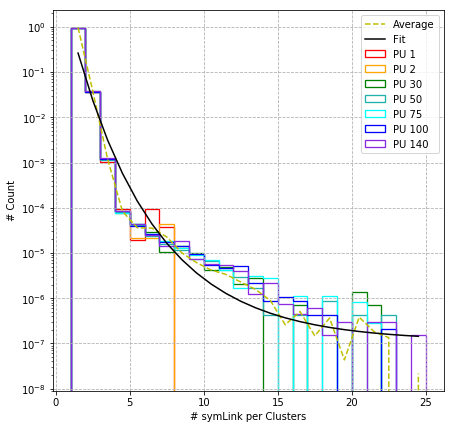

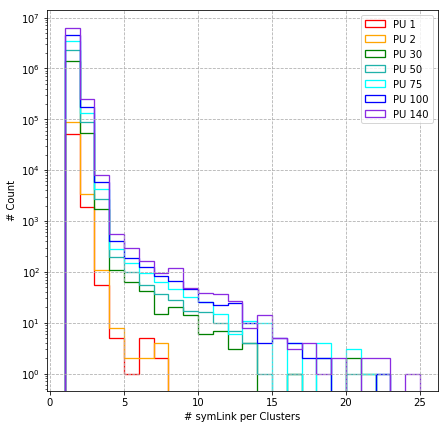

In [119]:
colors = { 
             '1':'r',
             '2':'orange',
            '10':'y',
            '20':'limegreen',
            '30':'g',
            '50':'lightseagreen',
            '75':'aqua',
           '100':'b',
           '140':'blueviolet',
           '175':'purple',
           '200':'k',
         }

M = []
xlim = 25
for normed in [True,False]:
    fig = plt.figure(figsize=(7,7))
    for pu in PU:
        h = plt.hist(
                    mergeP[pu],
                    histtype  = 'step',
                    range     = [1,xlim],
                    bins      = xlim-1,
                    label     = 'PU '+pu,
                    color     = colors[pu],
                    linewidth = 1.3,
                    normed    = normed,
                    )
        if normed:
            M.append(h[0])

    if normed:
        xc = (h[1][:-1]+h[1][1:])/2
        ave = sum(M)/len(M)
        plt.plot(xc,ave,'y--',label = 'Average')            
        
        func = exp2 #lamb, x0, N ,y0 
        P0 = [0.01,1,  1,-19]
        #func = Sexp #lamb, x0, N ,y0 
        #P0 = [0.1,1,  1,-19,0.1,1,  2,-19]
        yc = np.log(ave)
        mask = np.logical_not(np.isinf(yc))
        fit = curve_fit(func,xc[mask],yc[mask],p0=P0)
        plt.plot(xc,np.exp(func(xc,*fit[0])),'k-',label='Fit')
    
    ax = plt.gca()
    ax.set_yscale('log')
    #ax.set_xscale('log')
    plt.ylabel('# Count')    
    plt.xlabel('# symLink per Clusters')    
    plt.legend()
    plt.grid(linestyle='--')

    if normed :
        fig.savefig(figPath+'symLinkPerClusters_normed_'+str(xlim)+'.png')
    else:
        fig.savefig(figPath+'symLinkPerClusters_'+str(xlim)+'.png')
    plt.show();


/home/jcordero/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/jcordero/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in log
/home/jcordero/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in add
  import sys


0.0003971986652548946
Chi2::  1130545.2394539213


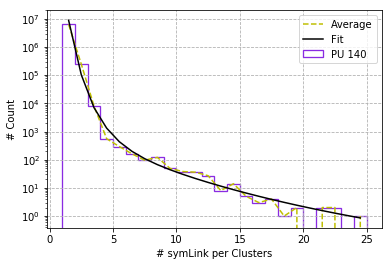

In [160]:
h = plt.hist(
            mergeP['140'],
            histtype  = 'step',
            range     = [1,xlim],
            bins      = xlim-1,
            label     = 'PU '+pu,
            color     = colors[pu],
            linewidth = 1.3,
            normed    = False,
            )


xc = (h[1][:-1]+h[1][1:])/2
#ave = sum(M)/len(M)
ave = h[0]
plt.plot(xc,ave,'y--',label = 'Average')            

#func = exp2 #lamb, x0, N ,y0 
#P0 = [0.01,1,  1,-19]
func = Sexp #lamb, x0, N ,y0 
P0 = [0.1, 1, 1,-19,
      0.1, 1, -4,-19]

yc = np.log(ave)
mask = np.logical_not(np.isinf(yc))
fit = curve_fit(func,xc[mask],yc[mask],p0=P0)
plt.plot(xc,np.exp(func(xc,*fit[0])),'k-',label='Fit')

ax = plt.gca()
ax.set_yscale('log')
#ax.set_xscale('log')
plt.ylabel('# Count')    
plt.xlabel('# symLink per Clusters')    
plt.legend()
plt.grid(linestyle='--')

    


y = np.exp(yc[mask])
sig = (np.sqrt(np.exp(yc[mask])))#* 1/len(mergeP)
mod = np.exp(func(xc[mask],*fit[0]))       
SIG = np.sqrt(sum(mergeP['140'][mergeP['140']==1]))
print(SIG/sum(mergeP['140'][mergeP['140']==1]))
Chi2 = sum(((mod-y)/sig)**2)
print('Chi2:: ',Chi2)

/home/jcordero/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/jcordero/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log


0.0003971986652548946
Chi2::  2413943.4048628868


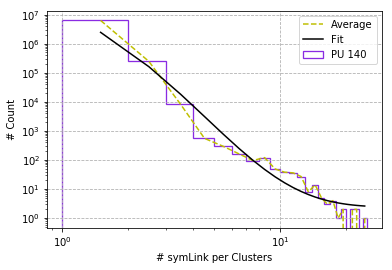

In [194]:
h = plt.hist(
            mergeP['140'],
            histtype  = 'step',
            range     = [1,xlim],
            bins      = xlim-1,
            label     = 'PU '+pu,
            color     = colors[pu],
            linewidth = 1.3,
            normed    = False,
            )


xc = (h[1][:-1]+h[1][1:])/2
#ave = sum(M)/len(M)
ave = h[0]
plt.plot(xc,ave,'y--',label = 'Average')            

func = exp2 #lamb, x0, N ,y0 
P0 = [0.01,1,  1,-19]
#func = Sexp #lamb, x0, N ,y0 
#P0 = [0.04, 18, 5,-2,
#      0.5, 0.9, 12,-2]
#P0 = [ 0.01, 10.91335664,  5.85414608, -2.44583224,  
#       2, -1, 12.36600433, -2.38991864]

yc = np.log(ave)
mask = np.logical_not(np.isinf(yc))
fit = curve_fit(func,xc[mask],yc[mask],p0=P0)
plt.plot(xc,np.exp(func(xc,*fit[0])),'k-',label='Fit')

y = np.exp(yc[mask])
sig = (np.sqrt(np.exp(yc[mask])))#* 1/len(mergeP)
mod = np.exp(func(xc[mask],*fit[0]))       
SIG = np.sqrt(sum(mergeP['140'][mergeP['140']==1]))
print(SIG/sum(mergeP['140'][mergeP['140']==1]))
Chi2 = sum(((mod-y)/sig)**2)
print('Chi2:: ',Chi2)

ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
plt.ylabel('# Count')    
plt.xlabel('# symLink per Clusters')    
plt.legend()
plt.grid(linestyle='--')


In [198]:
DE = 1131070/(25-8)
E  = 2413943/(25-4)

print(DE)
print(E)

66533.5294117647
114949.66666666667


In [205]:
pu = '1'
len(Size[pu][Size[pu] < 75 ])/len(Size[pu])

0.9998469543924089

In [329]:
def find(data,target=0.5,trailLenght= 0,Print=False):
    point = (max(data)+min(data))/2
    integral = (len(data[data < point])+trailLenght)/(len(data)+ trailLenght)
    
    if Print:
        print('len, point, integral, target, trail, error')
        print(len(data),point,integral,target,trailLenght,(integral - target)/target)
        
    if np.abs(integral - target)/target < 0.01: 
        return point
    elif integral - target > 0 :
        find(data[:int(len(data)/2)],
             target=target,
             trailLenght=trailLenght+int(len(data)/2),
             Print=Print)
    elif integral - target <= 0 :
        find(data[int(len(data)/2):],
             target=target,
             trailLenght=trailLenght+int(len(data)/2),
             Print=Print)        
    
    

In [330]:
def findPoint(data,n=1,target=0.95,curr = 0,Print=False):
    point = max(data)*(1-0.5/n)
    integral = len(data[data < point])/len(data)
    if Print:
        print(integral, point, integral < target)
    
    if integral - taget < 0.01:
        return point
    
    elif integral - target <  0:
        findPoint(data,n+1,target=target,Print=Print)
    else:
        return point
    

In [331]:
#findPoint(np.arange(100),cumulative = 0.6,Print = True)

find(np.arange(100),target = 0.8,Print=True)

len, point, integral, target, trail, error
100 49.5 0.5 0.8 0 -0.37500000000000006
len, point, integral, target, trail, error
50 74.5 0.75 0.8 50 -0.06250000000000006
len, point, integral, target, trail, error
25 87.0 0.87 0.8 75 0.08749999999999994
len, point, integral, target, trail, error
12 80.5 0.9393939393939394 0.8 87 0.17424242424242425
len, point, integral, target, trail, error
6 77.5 0.9696969696969697 0.8 93 0.2121212121212121
len, point, integral, target, trail, error
3 76.0 0.9797979797979798 0.8 96 0.22474747474747467
len, point, integral, target, trail, error
1 75.0 0.9897959183673469 0.8 97 0.2372448979591836


ValueError: max() arg is an empty sequence

In [332]:
maxSimLink = []
maxArea = []
maxSize = []
cumu = 0.5
for pu in PU:
    maxSimLink.append(findPoint(mergeP[pu],cumulative = cumu))
    maxArea.append(findPoint(Area[pu],cumulative=cumu))
    maxSize.append(findPoint(Size[pu],cumulative=cumu))
    
plt.figure()
plt.plot(PU,maxSimLink)
plt.grid(linestyle='--')

plt.figure()
plt.plot(PU,maxArea)
plt.grid(linestyle='--')

plt.figure()
plt.plot(PU,maxSize)
plt.grid(linestyle='--')

TypeError: findPoint() got an unexpected keyword argument 'cumulative'

/home/jcordero/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


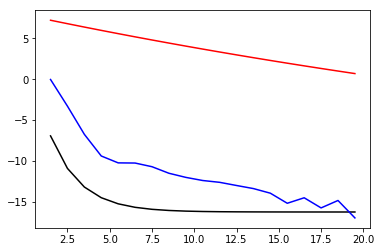

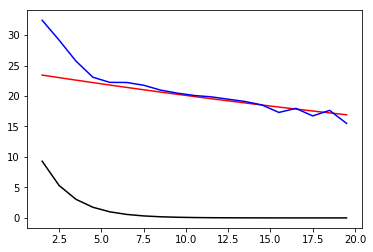

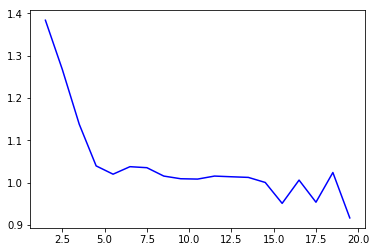

In [75]:
exp0Fit = fit[0][0:4]
exp1Fit = fit[0][4:8]

n = 5
xC = xc[:-n]
e2 = exp2(xc,*exp1Fit)[:-n]
e1 = exp2(xc,*exp0Fit)[:-n]
aveL = np.log(ave)[:-n]

#e1 = np.abs(e1)
#e2 = np.abs(e2)
#aveL = np.abs(aveL)

plt.figure()
plt.plot(xC,e2,'r-')
plt.plot(xC,e1,'k-')
plt.plot(xC,aveL,'b-')

plt.figure()
e2S = e2-exp1Fit[-1]
e1S = e1-exp0Fit[-1]
aveLS = aveL-exp1Fit[-1]-exp0Fit[-1]
plt.plot(xC,e2S,'r-')
plt.plot(xC,e1S,'k-')
plt.plot(xC,aveLS,'b-')

plt.figure()
plt.plot(xC,aveLS/e2S,'b-')


ax = plt.gca()
#ax.set_yscale('log')

# Area plots

In [77]:
Area = {}
for pu in PU:
    Area[pu] = (data[pu].CluArea)
area = [Area[a] for a in Area]

/home/jcordero/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


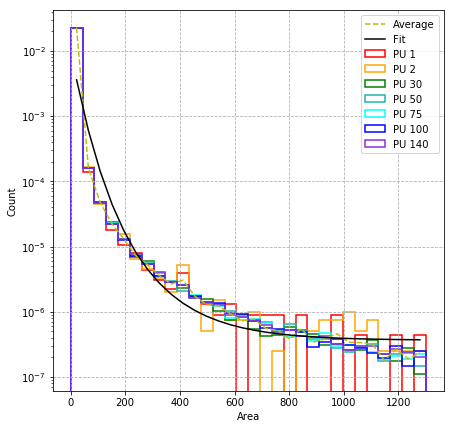

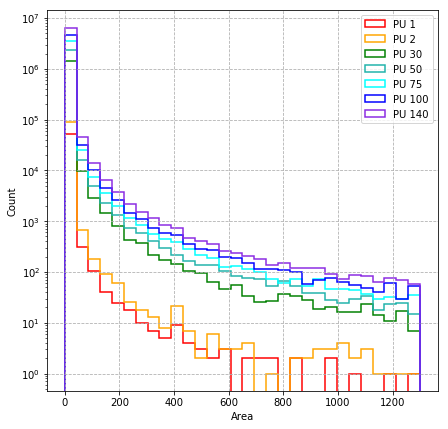

In [97]:
M = []

xlim,bins = 1300,30
for normed in [True,False]:
    fig = plt.figure(figsize=(7,7))
    for pu in PU:
        h = plt.hist(
                     Area[pu][mergeP[pu] <= 5],
                     histtype  = 'step',
                     range     = [0,xlim],
                     label     = 'PU '+pu,
                     bins      = bins,
                     normed    = normed,
                     color     = colors[pu],
                     linewidth = 1.5,
                    )
        M.append(h[0])
    if normed:
        xc = (h[1][:-1]+h[1][1:])/2
        ave = sum(M)/len(M)
        plt.plot(xc,ave,'y--',label = 'Average')
        
        func = exp2 #lamb, x0, N ,y0 
        P0 = [0.05,1,  0,-19]
        yc = np.log(ave)
        mask = np.logical_not(np.isinf(yc))
        fit = curve_fit(func,xc[mask],yc[mask],p0=P0)
        plt.plot(xc,np.exp(func(xc,*fit[0])),'k-',label='Fit')
    
    ax = plt.gca()
    ax.set_yscale('log')
    plt.ylabel('Count')
    plt.xlabel('Area')
    plt.legend()
    plt.grid(linestyle='--')
    plt.show();
    if normed :
        fig.savefig(figPath+'ClusArea_normed_'+str(xlim)+'.png')
    else:
        fig.savefig(figPath+'ClusArea_'+str(xlim)+'.png')

/home/jcordero/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


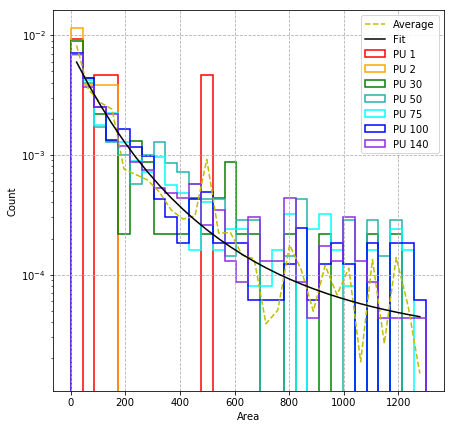

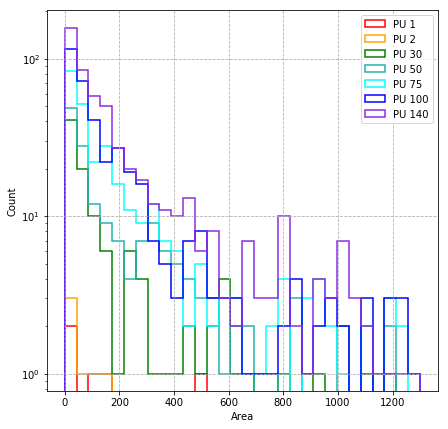

In [82]:
M = []

xlim,bins = 1300,30
for normed in [True,False]:
    fig = plt.figure(figsize=(7,7))
    for pu in PU:
        h = plt.hist(
                     Area[pu][mergeP[pu] > 5],
                     histtype  = 'step',
                     range     = [0,xlim],
                     label     = 'PU '+pu,
                     bins      = bins,
                     normed    = normed,
                     color     = colors[pu],
                     linewidth = 1.5,
                    )
        M.append(h[0])
    if normed:
        xc = (h[1][:-1]+h[1][1:])/2
        ave = sum(M)/len(M)
        plt.plot(xc,ave,'y--',label = 'Average')
        
        func = exp2 #lamb, x0, N ,y0 
        P0 = [0.05,1,  0,-19]
        yc = np.log(ave)
        mask = np.logical_not(np.isinf(yc))
        fit = curve_fit(func,xc[mask],yc[mask],p0=P0)
        plt.plot(xc,np.exp(func(xc,*fit[0])),'k-',label='Fit')
    
    ax = plt.gca()
    ax.set_yscale('log')
    plt.ylabel('Count')
    plt.xlabel('Area')
    plt.legend()
    plt.grid(linestyle='--')
    plt.show();
    if normed :
        fig.savefig(figPath+'ClusArea_normed_'+str(xlim)+'.png')
    else:
        fig.savefig(figPath+'ClusArea_'+str(xlim)+'.png')

# Size plots

In [84]:
Size = {}
for pu in PU:
    Size[pu] = data[pu].CluSize
size = [Size[s] for s in Size]

/home/jcordero/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/jcordero/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in log


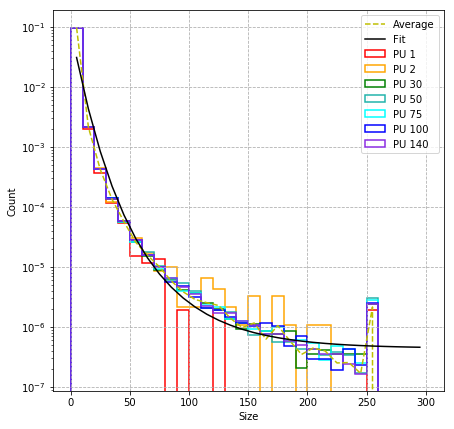

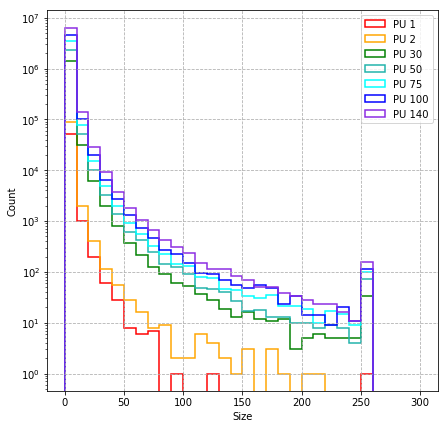

In [91]:
M = []

xlim,bins = 300,30
for normed in [True,False]:
    fig = plt.figure(figsize=(7,7))
    for pu in PU:
        h = plt.hist(
                     Size[pu][mergeP[pu] <= 5],
                     histtype  = 'step',
                     range     = [0,xlim],
                     label     = 'PU '+pu,
                     bins      = bins,
                     normed    = normed,
                     color     = colors[pu],
                     linewidth = 1.5,
                    )
        M.append(h[0])
    if normed:
        xc = (h[1][:-1]+h[1][1:])/2
        ave = sum(M)/len(M)
        plt.plot(xc,ave,'y--',label = 'Average')
        
        func = exp2 #lamb, x0, N ,y0 
        P0 = [0.01,1,  0,-19]
        yc = np.log(ave)
        mask = np.logical_not(np.isinf(yc))
        fit = curve_fit(func,xc[mask],yc[mask],p0=P0)
        plt.plot(xc,np.exp(func(xc,*fit[0])),'k-',label='Fit')
    
    ax = plt.gca()
    ax.set_yscale('log')
    plt.ylabel('Count')
    plt.xlabel('Size')
    plt.legend()
    plt.grid(linestyle='--')
    plt.show();
    if normed :
        fig.savefig(figPath+'ClusArea_normed_'+str(xlim)+'.png')
    else:
        fig.savefig(figPath+'ClusArea_'+str(xlim)+'.png')

/home/jcordero/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/jcordero/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in log


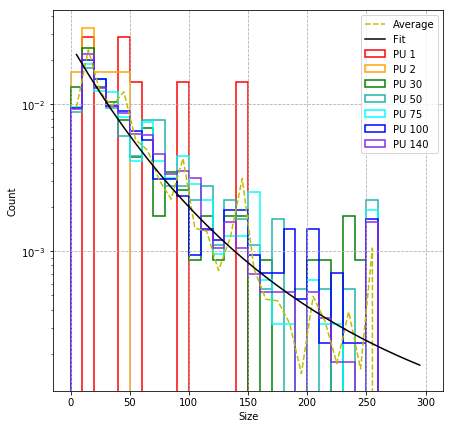

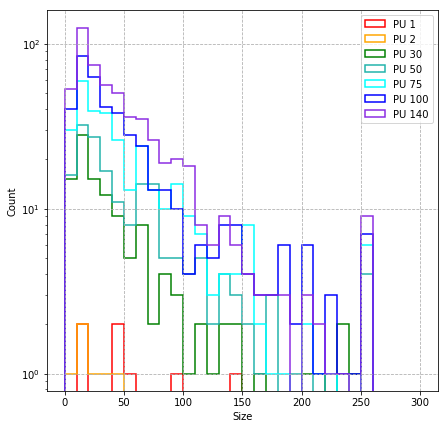

In [90]:
M = []

xlim,bins = 300,30
for normed in [True,False]:
    fig = plt.figure(figsize=(7,7))
    for pu in PU:
        h = plt.hist(
                     Size[pu][mergeP[pu] > 5],
                     histtype  = 'step',
                     range     = [0,xlim],
                     label     = 'PU '+pu,
                     bins      = bins,
                     normed    = normed,
                     color     = colors[pu],
                     linewidth = 1.5,
                    )
        M.append(h[0])
    if normed:
        xc = (h[1][:-1]+h[1][1:])/2
        ave = sum(M)/len(M)
        plt.plot(xc,ave,'y--',label = 'Average')
        
        func = exp2 #lamb, x0, N ,y0 
        P0 = [0.05,1,  0,-19]
        yc = np.log(ave)
        mask = np.logical_not(np.isinf(yc))
        fit = curve_fit(func,xc[mask],yc[mask],p0=P0)
        plt.plot(xc,np.exp(func(xc,*fit[0])),'k-',label='Fit')
    
    ax = plt.gca()
    ax.set_yscale('log')
    plt.ylabel('Count')
    plt.xlabel('Size')
    plt.legend()
    plt.grid(linestyle='--')
    plt.show();
    if normed :
        fig.savefig(figPath+'ClusArea_normed_'+str(xlim)+'.png')
    else:
        fig.savefig(figPath+'ClusArea_'+str(xlim)+'.png')